In [21]:
from __future__ import absolute_import

#check if there is an evirronment variable called ROOT_PATH
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

# import local_settings
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from runners import Runner


In [22]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 300
TfN2 = 100

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

playlist = {
# 'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
# 'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 140)],
# 'spOVRrecovery': [(P0, 192),
#                (Pplus, 1000),
#                (Pminus, 20),
#                (Pchannel, 400)],
'evrecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 2),
               (Pplus, 2),
               (Pchannel, 140)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 384),
#                (Pchannel, 400)],    
# 'AB0':[(P0, TaN),(Pminus, TaB)],
# 'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
# 'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
# 'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
# 'ANB0':[(P0, TaN),(Pminus, TaB)],
# 'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
# 'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
# 'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

# hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [23]:
# frog_playlist = {
# f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

# frog_playlist_a = {
# f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

# frog_playlist.update(frog_playlist_a)

In [24]:
test_vec= np.stack([np.zeros(200),
                    np.zeros(200),
                    np.zeros(200),
                   np.linspace(2*Pminus,2*Pplus,200)]).T

x_test = test_vec[:,-1]


In [25]:
cnt =0

results = {}
ws =  [0.05 ,0.1,0.2,0.5]
skips = [0., 0.5, 0.9]  #[0, 0.2, 0.5]
for s, skip in enumerate(skips):
    for i, w in enumerate(ws):
        model_construct_args =  dict(n_inputs = 4,
                          n_hidden = 5*4*512,
                          n_outs = 1,
                          en_bias = False,
                         b_high=w, first_layer_init='uniform_unity',
                        first_layer_weights_trainable = True,
                        out_layer_init='zeros',
                          nl = 'relu', skip_gain= skip)
        setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':0.5e-5, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True}
        runner = Runner(model_construct_args=model_construct_args,
                        test_vec=test_vec,
                        **setting)
        results[(s,i)] = runner.run_multiple(playlist)

running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evr

In [29]:
def do_plots(results,playlist,figsize=(18, 6)):
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.ylim([1.5*Pminus,1.5*Pplus])
    plt.grid(True)
    plt.xlabel('trials')
    plt.ylabel('adaptation')

    plt.subplot(1,3,2)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    plt.ylim([1.5*Pminus,1.5*Pplus])
    plt.grid(True)
    plt.xlabel('trials')
    plt.ylabel('adaptation')


    plt.subplot(1,3,3)
    
    times = [1, 170, 185]
    colors = ['tab:red','tab:blue','tab:orange','tab:green']
    paradigm = 'sprecovery'
    plt.plot(x_test,x_test,'k:')
    for i,time in enumerate(times):
        u_test = results[paradigm].test_output[time]
        plt.plot(x_test,u_test,colors[i])
        u_t = results[paradigm].u_lp[time]
        plt.plot(u_t, u_test[np.argmin(np.abs(x_test-u_t))],'*',color=colors[i])
    plt.ylim([1.5*Pminus,1.5*Pplus])
    plt.grid(True)
    plt.xlabel('model input')
    plt.ylabel('model output')

    # for t in [170,185]:
    #     plt.plot(results['sprecovery'].test_output[t])
    # plt.show()

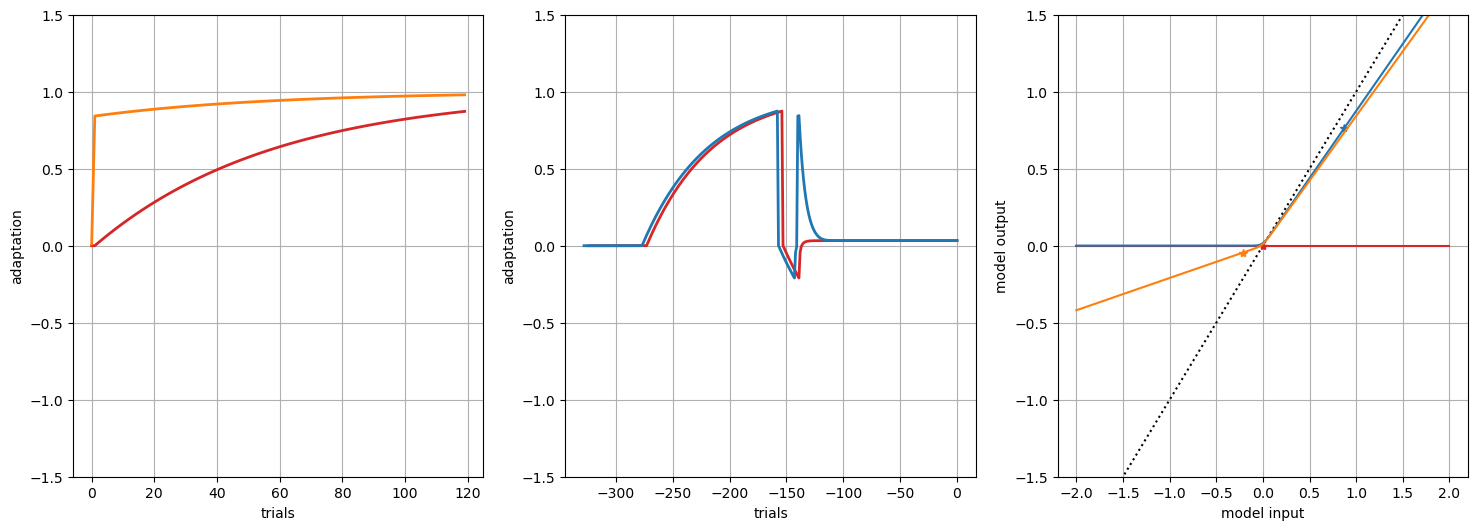

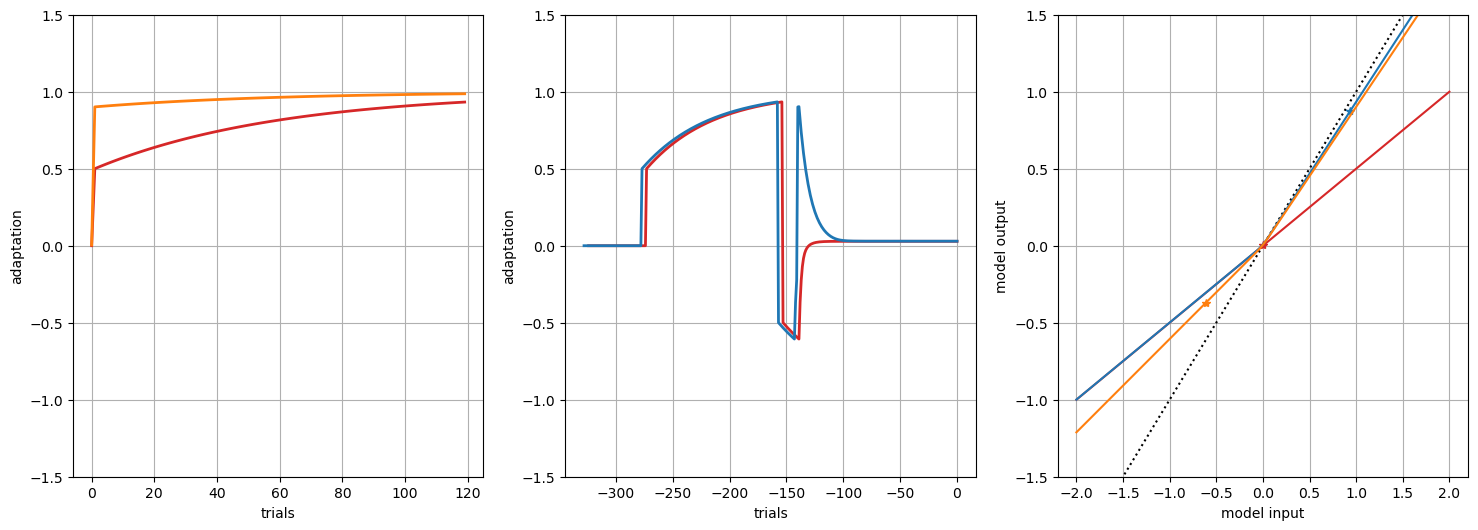

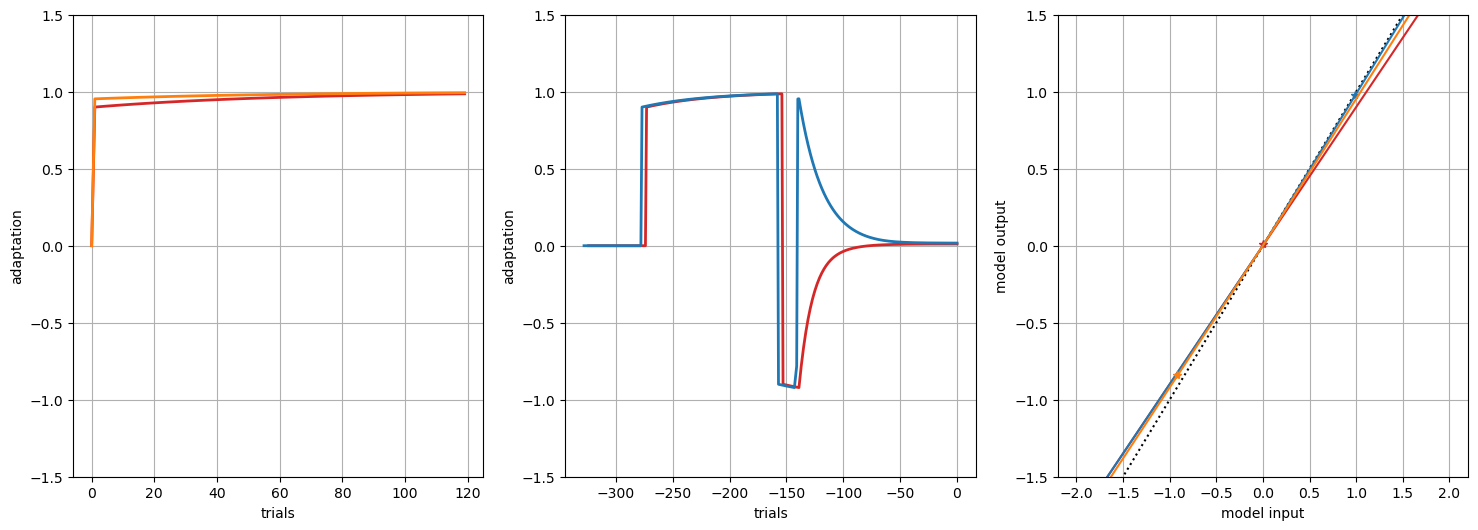

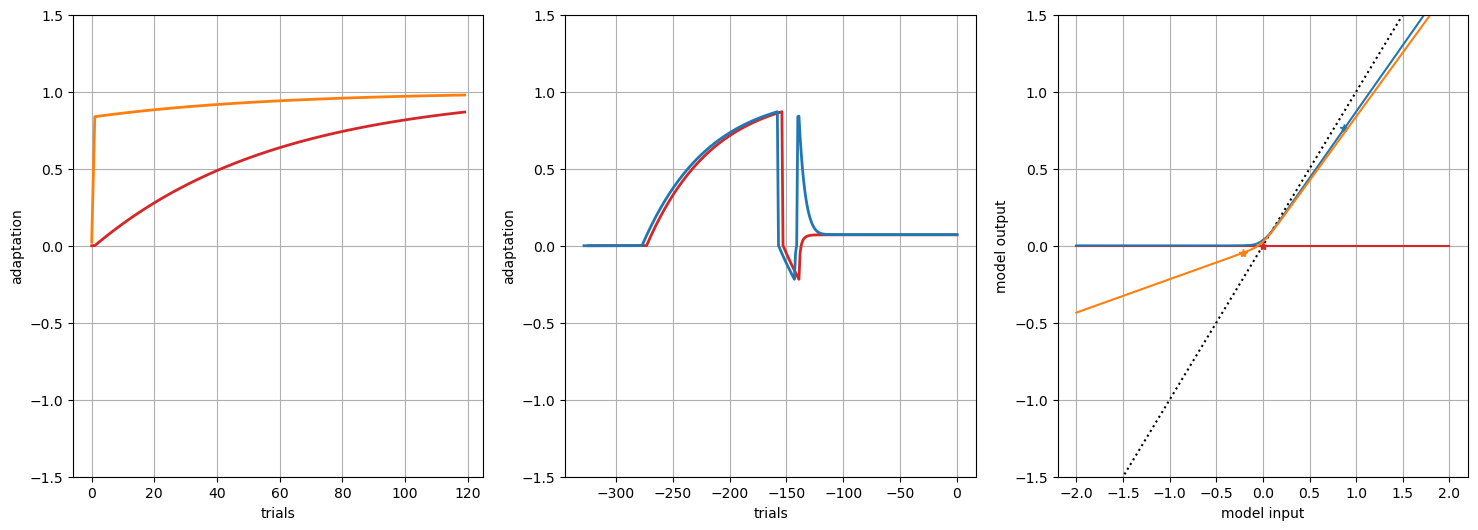

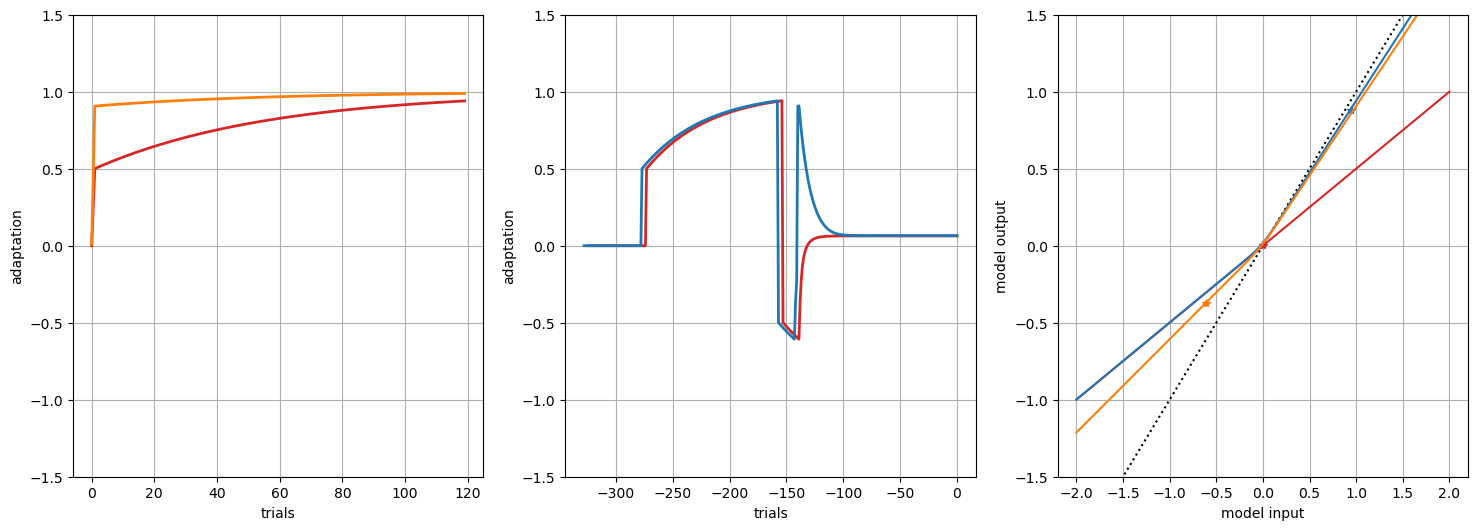

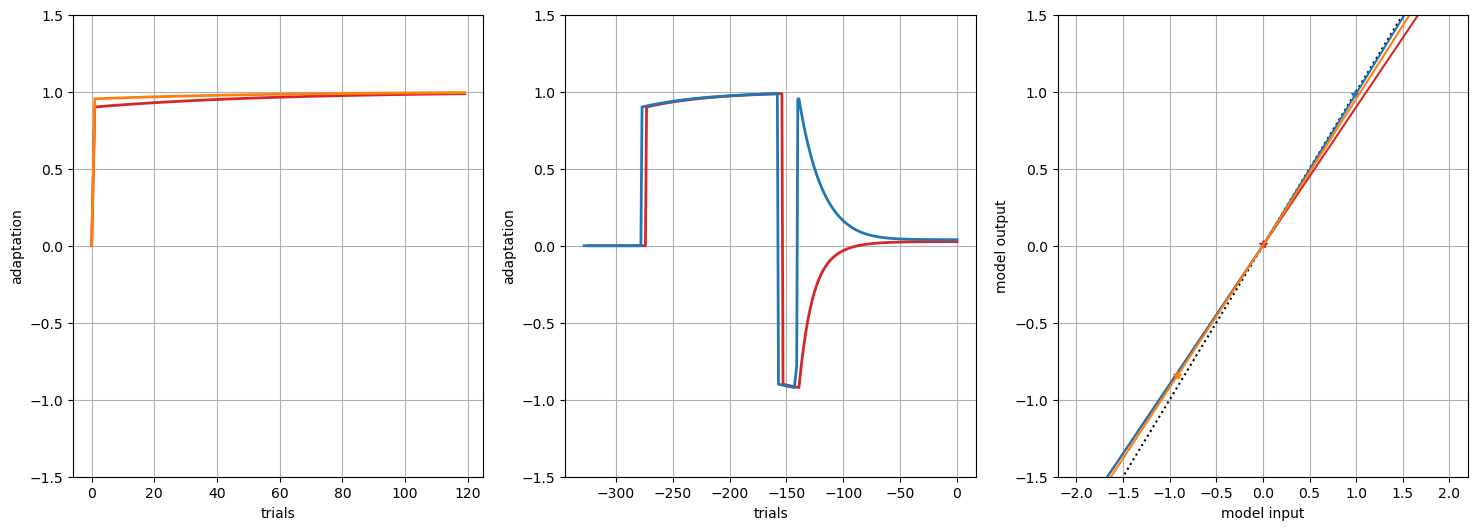

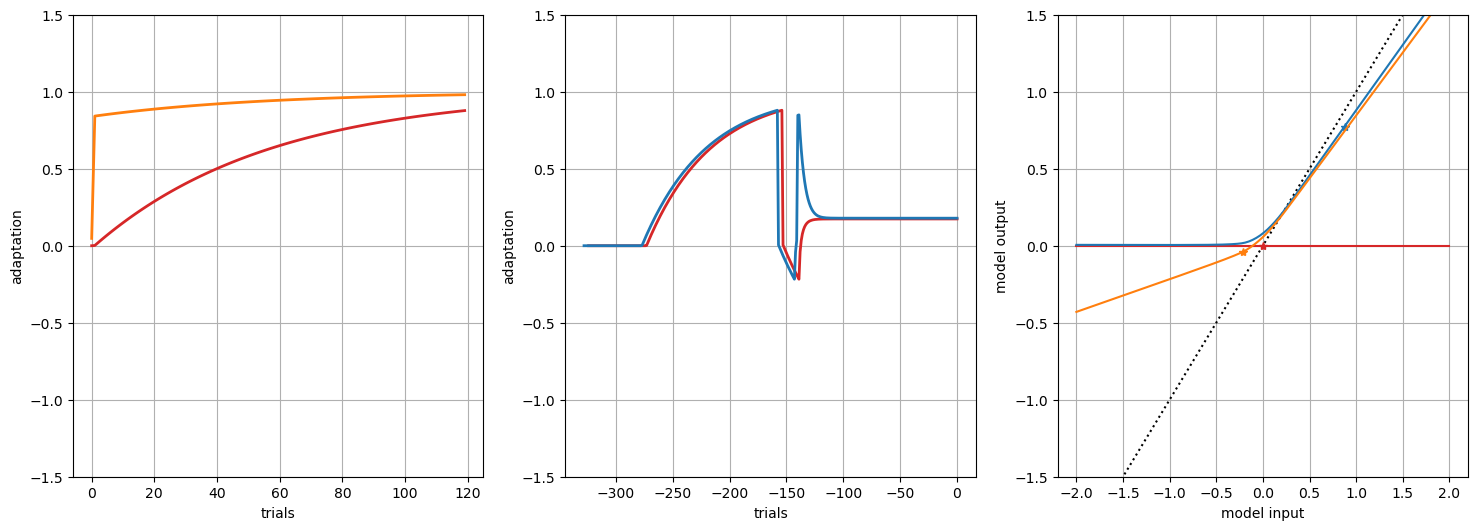

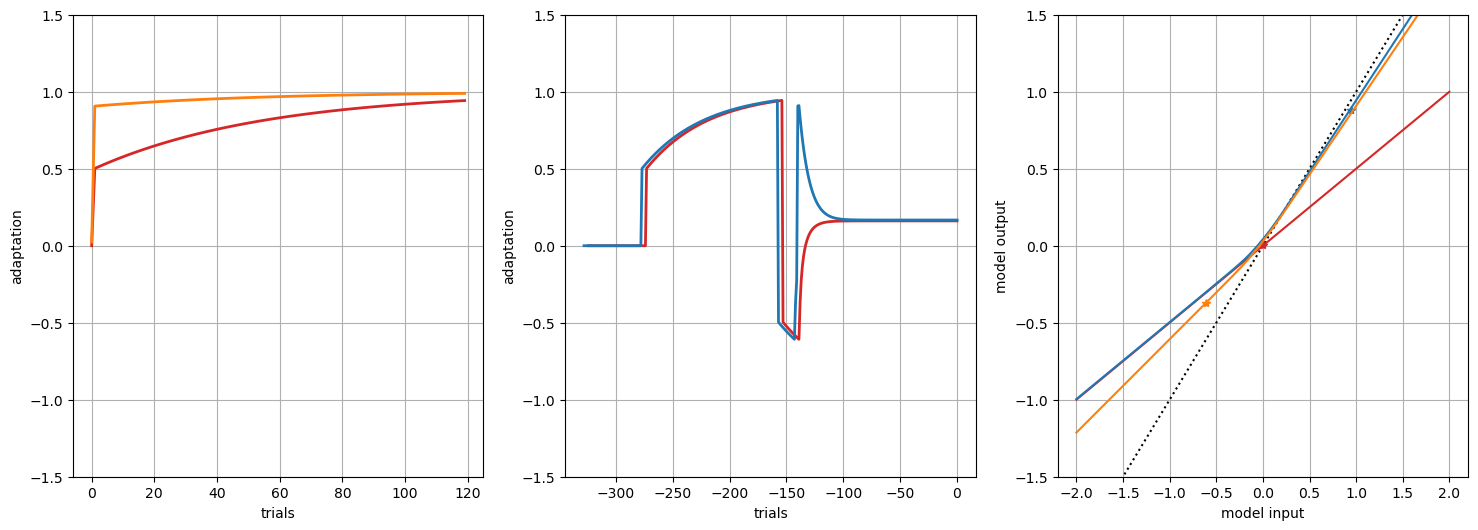

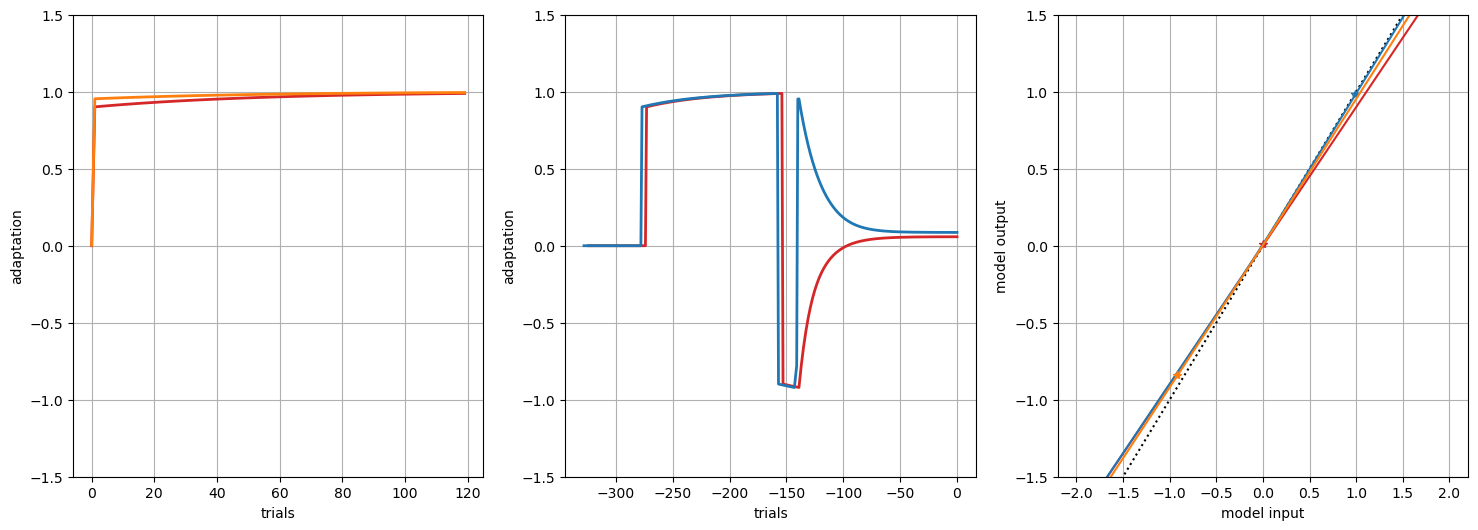

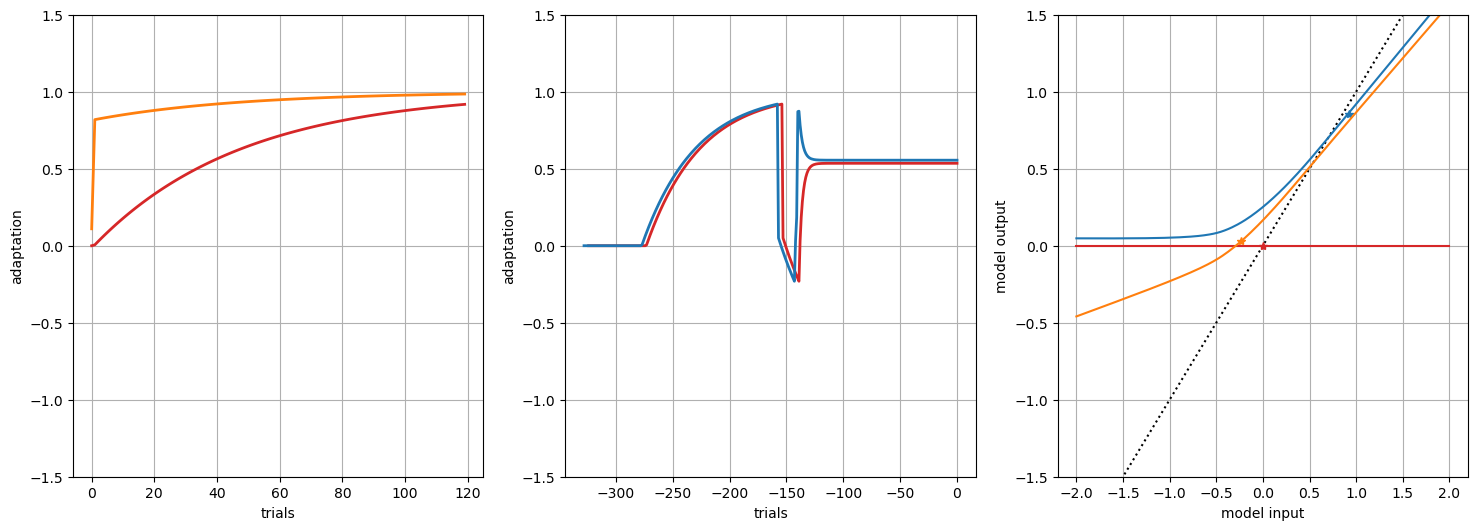

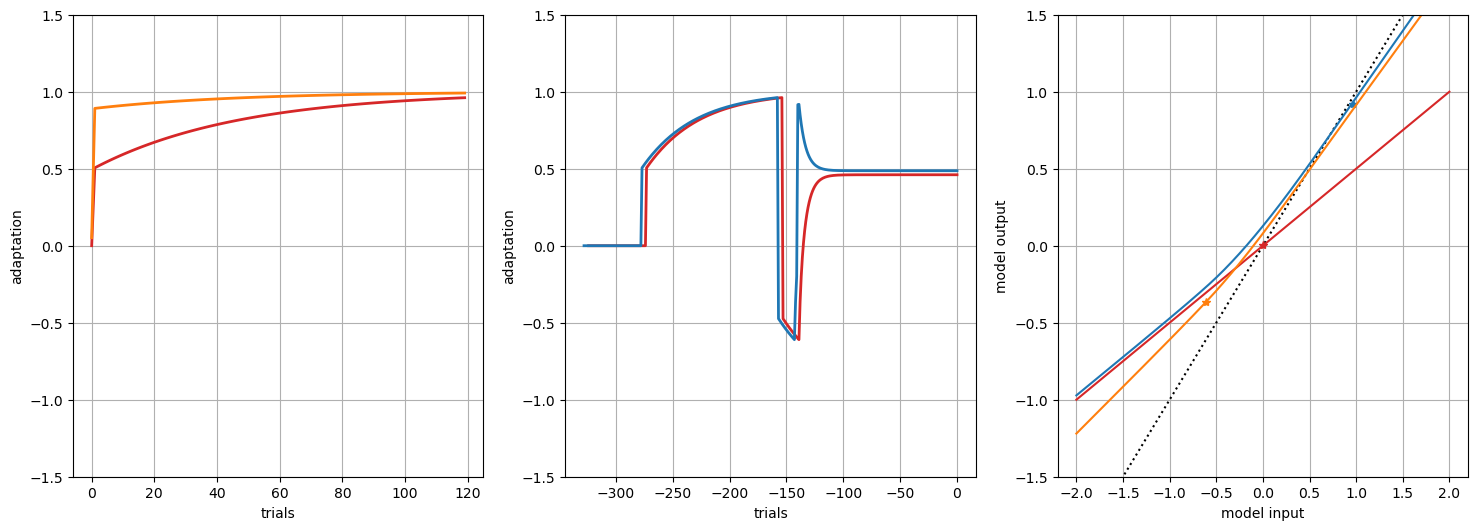

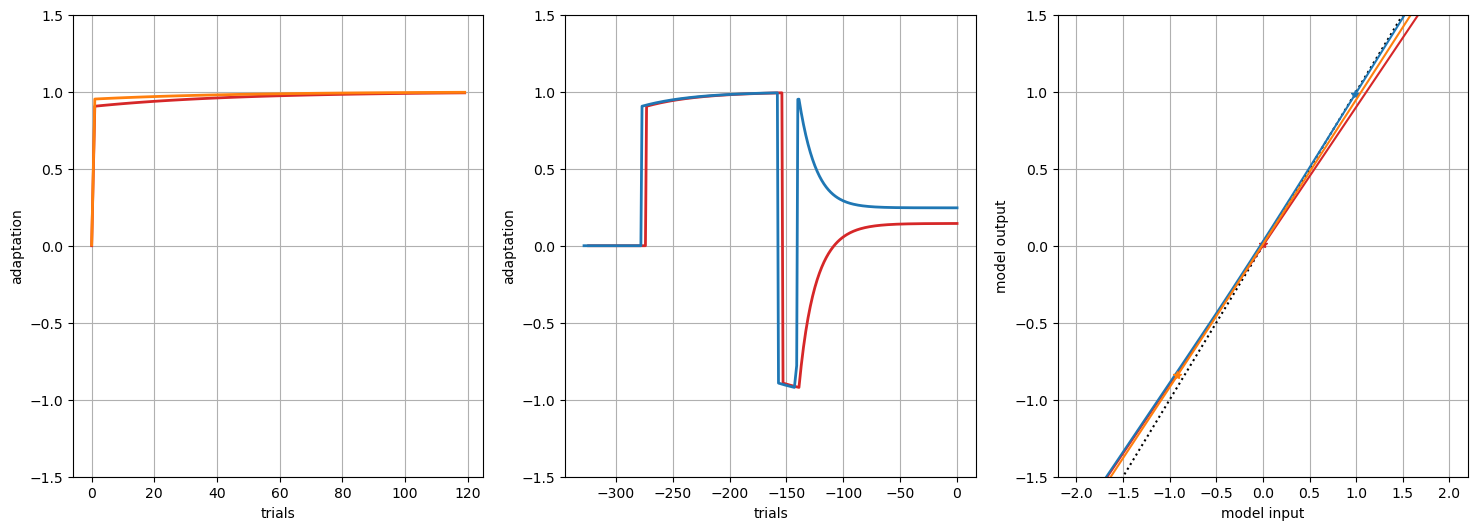

In [30]:
for i,w in enumerate(ws):
    for s,skip in enumerate(skips):
        item = (s,i)
        do_plots(results[item],playlist)


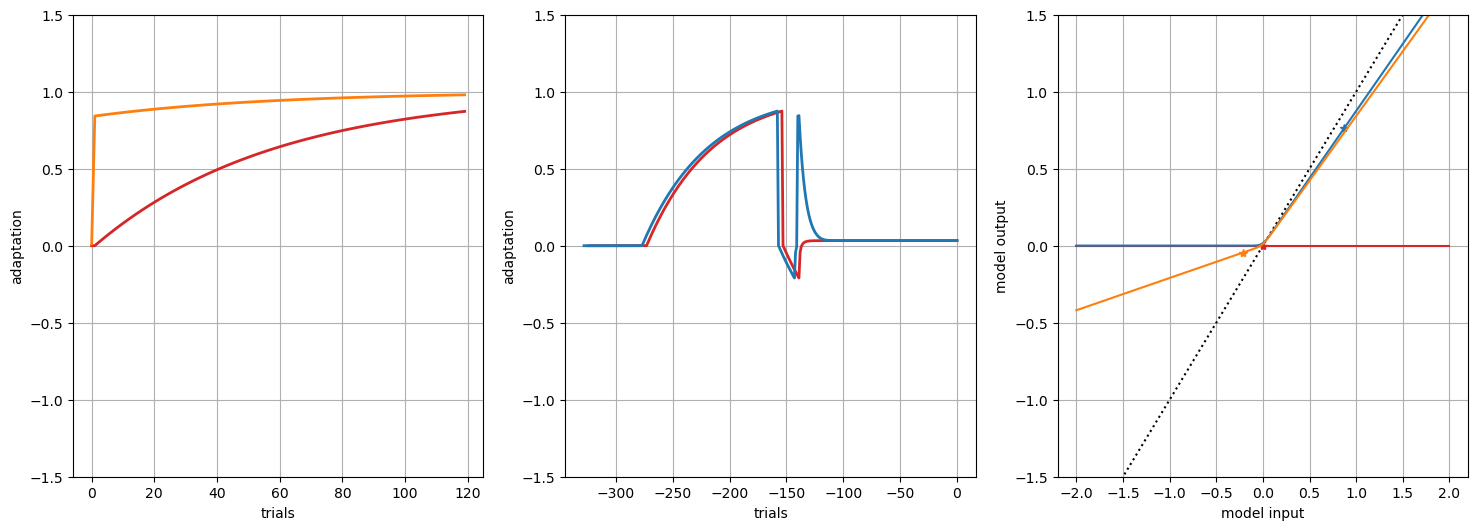

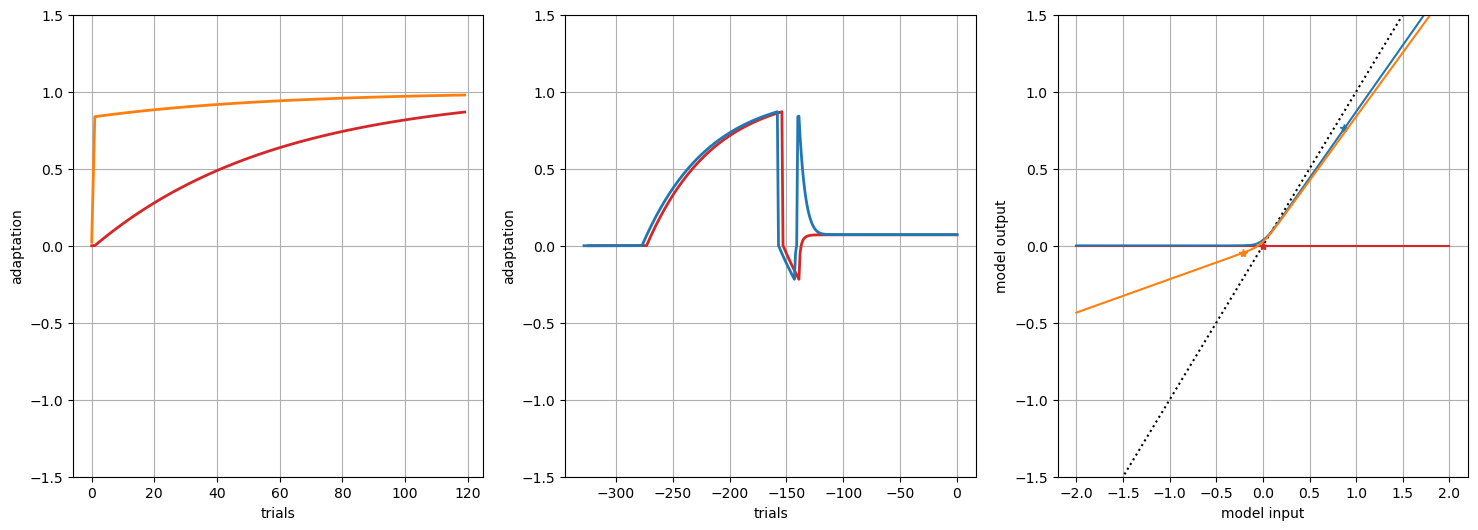

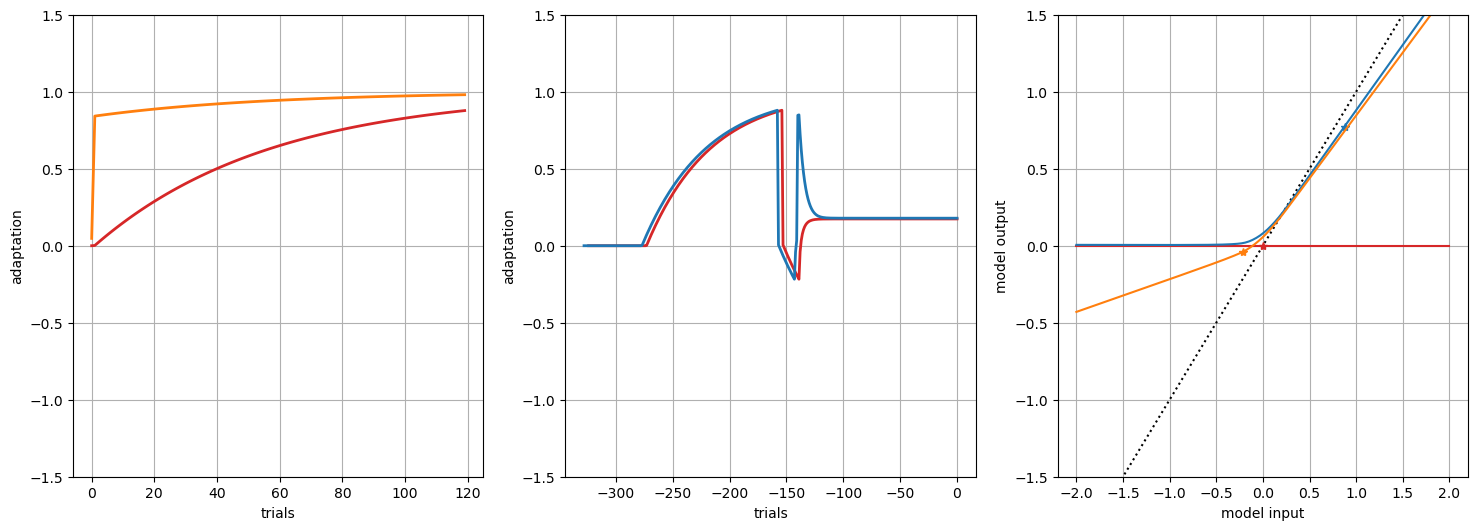

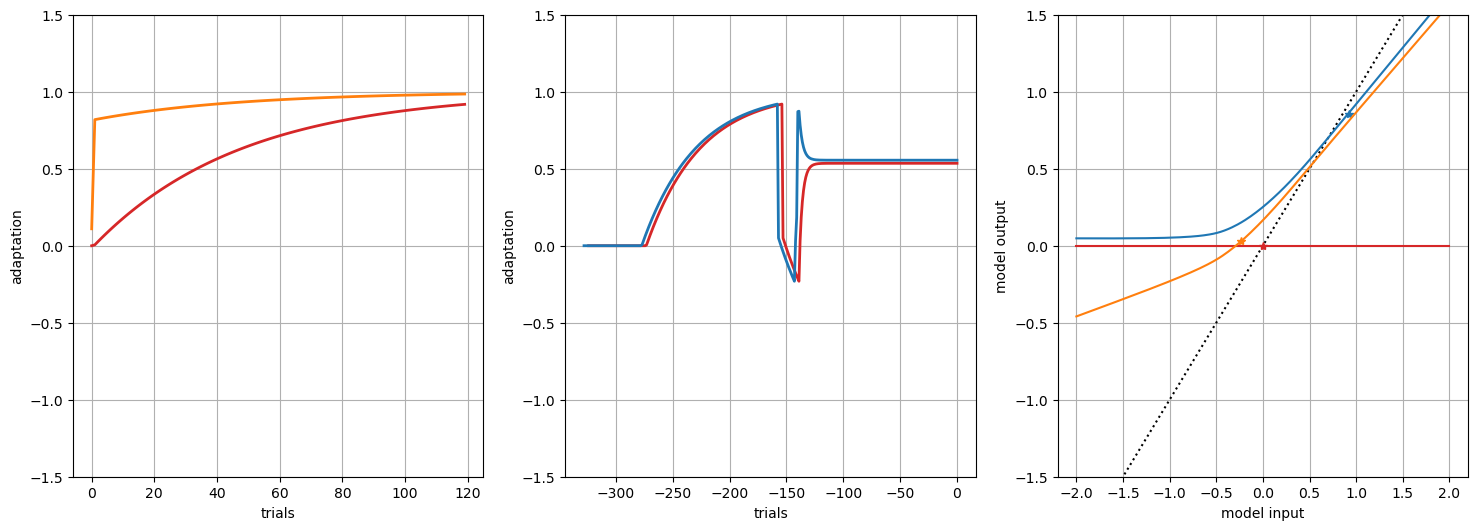

In [31]:
for i,w in enumerate(ws):
    for s,skip in enumerate(skips[:1]):
        item = (s,i)
        do_plots(results[item],playlist)
        